In [2]:
import pandas as pd
import numpy as np

from numpy.linalg import norm
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

import itertools
import json

import matplotlib.pyplot as plt
%matplotlib inline

Extract network features and use them to compute similarity between 20 seeds in the <b>finance domain</b> and <b>random users</b>.

The idea is to keep part of the seeds as seeds and the other part as good candidates, while all the random users are bad candidates. In this way it is possible to assess automatically the goodness of the method, because the groundtruth is already validated.

Steps to follow:
1. Split seeds in candidates and effective seeds (10/10) - <b> define shared list of combinations </b>
2. Compute centroid with effective seeds
3. Rank random users and candidates with respect to the centroid
4. Compute #good candidates extracted at each level of ranking and plot the resulting line against the random ranking (linear)
5. Iterate with different splits
6. Compare with respect to the fingerprint method

In [19]:
def candidatesRanking(candidates, centroid, features):
    #centroid_v = np.array(centroid[features])
    
    output = pd.DataFrame()
    
    output['username'] = candidates['username']
    output['id_user'] = candidates['id_user']
    
    # ranking based on distance similarity
    # output['distance'] = candidates.apply(lambda x: norm(np.array(x[features]) - centroid), axis=1)
    # output['similarity'] = output.apply(lambda x: 1/(1+x['distance']), axis=1)
    
    # ranking based on cosine similarity
    output['similarity'] = candidates.apply(lambda x: cosine_similarity(
                                            np.array(x[features]).reshape(1, -1), centroid.reshape(1, -1)
                                            ), axis=1)
    
    output.sort_values(by='similarity', ascending=False, inplace=True)
    
    # reset_index -> index+1 becomes the ranking
    output.reset_index(inplace=True)
    
    return output

In [4]:
def computeCentroid(seeds, normheader):
    arrays = [np.array(x[normheader]) for index, x in seeds.iterrows()]
    
    return np.sum(arrays, axis=0)/seeds.shape[0]

In [5]:
def cumulativeGoodCandidates(ranking):
    cumulative = []
    n_good_candidates = 0
    
    for index, ranked_user in ranking.iterrows():
        if ranked_user['good'] == True:
            n_good_candidates = n_good_candidates + 1
        cumulative.append(n_good_candidates)
        
    return np.array(cumulative)

In [6]:
def plotData(seeds, candidates, components, centroids = None):
    x = components[0]
    y = components[1]
    
    plt.figure(figsize=(12,12))
    plt.scatter(candidates[x], candidates[y], marker='.', s=40, lw=0, alpha=0.7)
    plt.scatter(seeds[x], seeds[y], marker='x', color='red')
    
    if centroids is not None:
        for c in centroids:
            plt.scatter(c[0], c[1], marker='o', color='black')

In [7]:
def computeSimDistribution(ranking, float_prec):
    prec_str = '%.{}f'.format(float_prec)
    ranking['truncated'] = ranking.apply(lambda x: float(prec_str%(x['similarity'])), axis=1)
    
    y = ranking.groupby(by='truncated').count().reset_index()[['truncated','similarity']]
    y.columns = ['sim','freq']
    y.sort_values(by='sim', inplace=True)
    
    return y

In [8]:
header = ['{}'.format(i) for i in range(1,9)]

# Run tests with fixed combinations

In [9]:
allseeds = list(map(str, pd.read_csv('../data-seed/fashion/user.csv', sep='\t')['screen_name']))
combinations = json.load(open('combinations.json', 'rb'))

In [10]:
allseeds

['edwardcordobab',
 'cortomoltedo',
 'aincontri',
 'angelosfrentzos',
 'andrea_pompilio',
 'maisonalbino',
 '10acompany',
 'arthurarbesser',
 'alabmilano',
 'angelosbratis',
 'aujourlejour_',
 'amenstyle',
 'arnoldoebattois',
 '2w2m',
 '1darklevel',
 'aquilanorimondi',
 'abrahamkhangul1',
 'alessia_xoccato']

In [11]:
len(combinations)

100

In [11]:
# first 50 combinations
combinations = {k: v for k, v in combinations.iteritems() if int(k)<50}

AttributeError: 'dict' object has no attribute 'iteritems'

In [12]:
domain = 'fashion'
datapath = '../data-seed/{}/'.format(domain)
path = 'random-test/test-network-features/'.format(domain)

In [13]:
# define function to apply the same analysis to all the datasets
def computePerformance(allseeds, comb, data, network_type):
    
    candidates_ranking = {}
    for u in allseeds:
        candidates_ranking[u] = []

    # store everyone ranking to check if, on average, some interesting user comes up
    all_ranking = {}
    for u in list(data['username']):
        all_ranking[u] = []
    
    ysum = np.zeros(data.shape[0] - 9)
    prec_20 = []
    prec_10 = []
    
    for c in comb:
        effective_seeds = [x.lower() for x in comb[c]] #lower case for usernames
        good_candidates = list(set(allseeds)-(set(effective_seeds)))
        seedsVectors = data[data['username'].isin(effective_seeds)]
        centroid = computeCentroid(seedsVectors, header)
        candidates = data[~data['username'].isin(effective_seeds)]

        r = candidatesRanking(candidates, centroid, header)
        r['good'] = r.apply(lambda x: True if x['username'] in good_candidates else False, axis=1)

        y = cumulativeGoodCandidates(r)
        ysum = ysum + y

        for index, candidate in r[r['good'] == True].iterrows():
            username = candidate['username']
            candidates_ranking[username].append(index+1)

        for index, candidate in r.iterrows():
            username = candidate['username']
            all_ranking[username].append(index+1)

        prec_20.append(cumulativeGoodCandidates(r[:20])[19])
        prec_10.append(cumulativeGoodCandidates(r[:10])[9])

    y_avg = ysum.astype(float)/len(combinations)
    
    plt.figure(figsize=(14,8))
    plt.title('Cumulative good candidates for {} network'.format(network_type))
    plt.ylabel('#good candidates')
    plt.xlabel('ranking position')

    plt.plot(y_avg)
    plt.plot([0, len(y_avg)],[0, 9], linestyle='--', color='black')
    plt.xlim(xmin=1)

    plt.yticks(range(1,10))
    plt.grid(True)
    
    print ('Average P@20: {:.2f}'.format(np.mean(prec_20)))
    print ('Average P@10: {:.2f}'.format(np.mean(prec_10)))
              
    return [y_avg, candidates_ranking, all_ranking]

In [14]:
def extract_top_list(ranking, K):
    result = []
    for username in sorted(ranking, key=ranking.get):
        result.append(tuple(
            (username, np.mean(ranking[username]))
        ))
    
    return pd.DataFrame(result, columns=['screen_name', 'ranking']).sort_values(by='ranking')[:K]

In [15]:
test = 1

seed_data = pd.read_csv(datapath+'/user.csv', sep='\t')
seed_data['usertype'] = 'seed'

# test ids needed to filter the mentioned/following/followed users (they are not included in the ranking)
testusers = pd.read_csv('../data-random/user.csv', sep='\t')

## Hashtags Network Test - 1

Average P@20: 4.09
Average P@10: 2.83


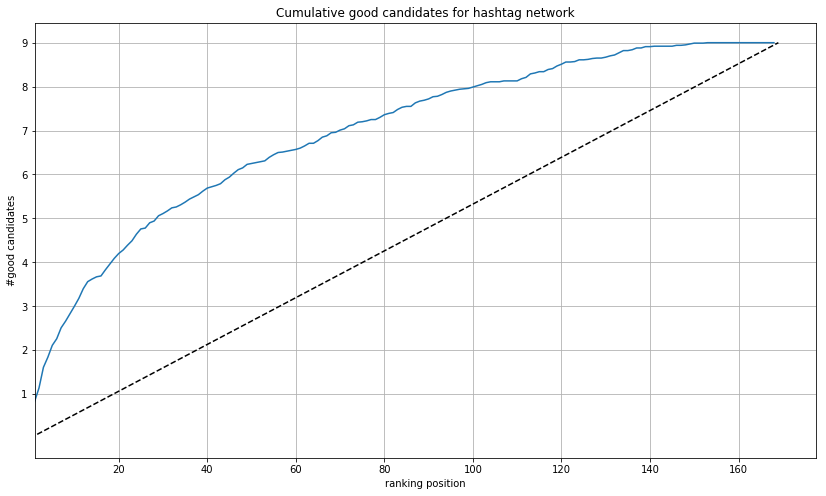

In [20]:
# features file reading and metadata inclusion
userdata = pd.read_csv(path+'h_network_{}_nodes.csv'.format(test), sep='\t') # match graph id and user instance
data = pd.read_csv(path+'h_network_{}.emb'.format(test), sep=' ', header=None, skiprows=1)
data = userdata.merge(data, left_on='id', right_on=0)
data.drop(0, inplace=True, axis=1)
data.columns = ['id_graph','username','id_user','usertype']+header

data = data[data['usertype'].isin(['seed','user'])]
data.reset_index(inplace=True)

perf_tag, candidate_rank, all_rank = computePerformance(allseeds, combinations, data, 'hashtag')

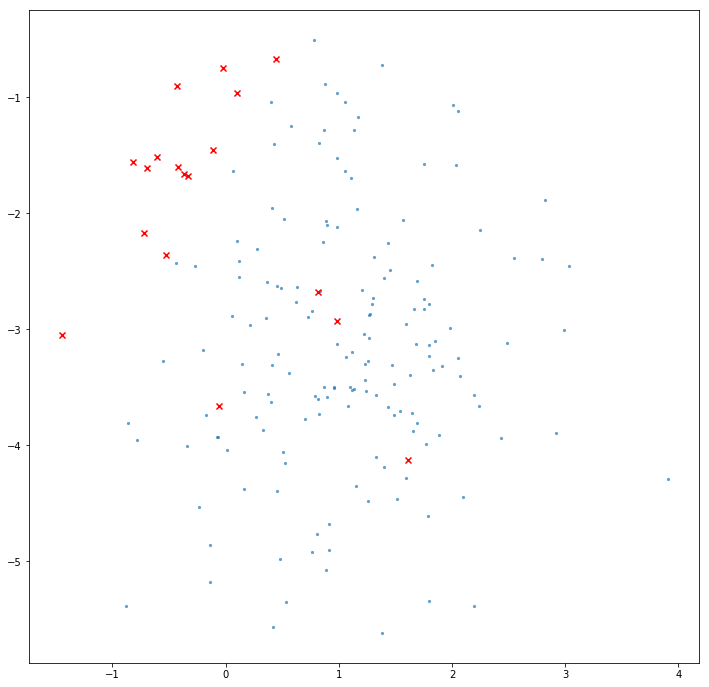

In [15]:
plotData(data[data['usertype'] == 'seed'], data[data['usertype']=='user'], header)

## Mention Network Test - 1

Average P@20: 1.50
Average P@10: 0.98


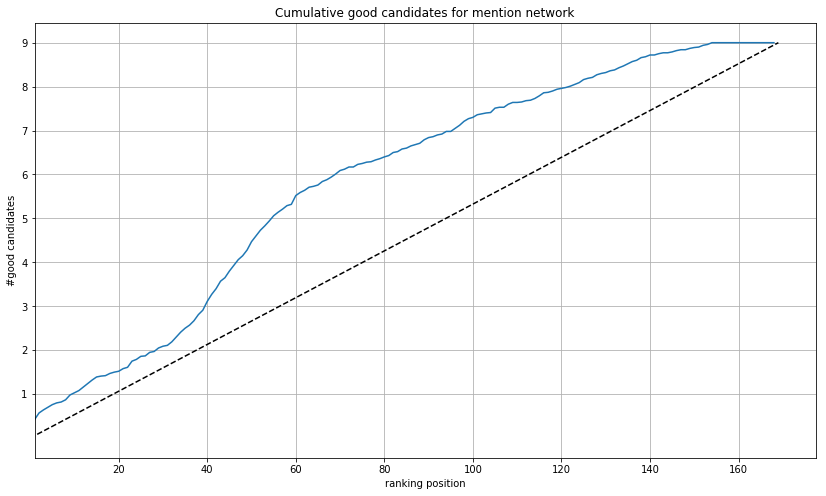

In [21]:
# features file reading and metadata inclusion
userdata = pd.read_csv(path+'m_network_{}_nodes.csv'.format(test), sep='\t') # match graph id and user instance
userdata = userdata[userdata['id_node'].isin(['seed', 'user'])]

data = pd.read_csv(path+'m_network_{}.emb'.format(test), sep=' ', header=None, skiprows=1)
data = userdata.merge(data, left_on='id', right_on=0)

data.drop(0, inplace=True, axis=1)
data.columns = ['id_graph','username','id_user','usertype']+header
data['id_user'] = data['id_user'].astype(int)

# keeps only seeds and test users for the evaluation
t1_users = testusers[testusers['n_test'] == test][['id_user', 'screen_name']].drop_duplicates()
t1_users['usertype'] = 'user'
data = data.merge(pd.concat([seed_data[['id_user', 'screen_name', 'usertype']], t1_users]), on='id_user')

perf_mention, candidate_rank, all_rank = computePerformance(allseeds, combinations, data, 'mention')

In [17]:
extract_top_list(all_rank, 20)

,screen_name,ranking
49,maisonalbino,7.785714
47,rjones,13.320000
55,zetikala,13.380000
60,leewmurdock,13.960000
9,neiled,14.060000
7,ramalagianambi,14.680000
33,chrisfralic,14.740000
46,biz,14.820000
12,dunstan,16.360000
5,arthurarbesser,17.600000


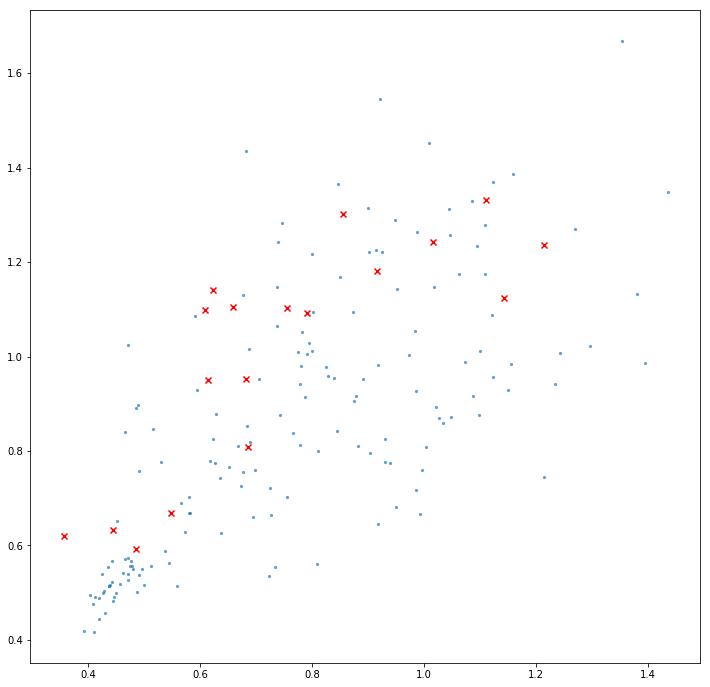

In [18]:
plotData(data[data['usertype_x'] == 'seed'], data[data['usertype_x']=='user'], header)

## Following Network Test - 1

Average P@20: 9.00
Average P@10: 9.00


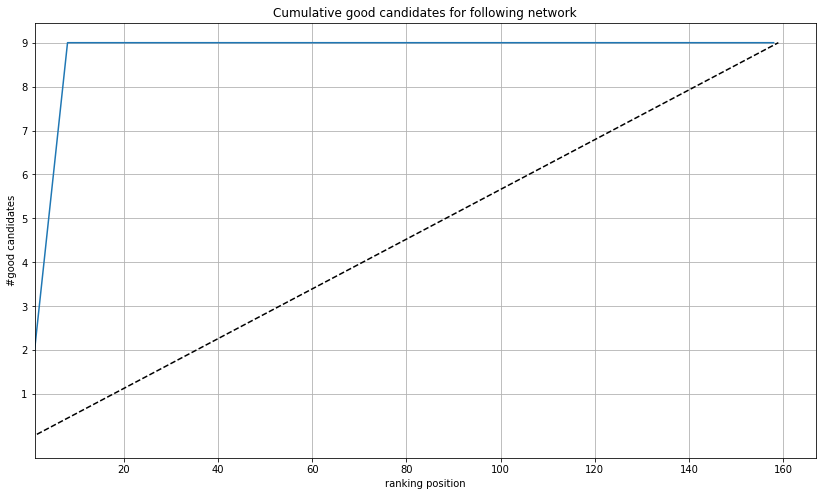

In [22]:
# features file reading and metadata inclusion
userdata = pd.read_csv(path+'social_network_{}_following_nodes.csv'.format(test), sep='\t')
data = pd.read_csv(path+'social_network_{}_following.emb'.format(test), sep=' ', header=None, skiprows=1)
data = userdata.merge(data, left_on='id', right_on=0)
data.drop(0, inplace=True, axis=1)

# need to add usernames, too and filter the mentioned users that should not be included
t1_users = testusers[testusers['n_test'] == test][['id_user', 'screen_name']].drop_duplicates()
t1_users['usertype'] = 'user'
data = data.merge(pd.concat([seed_data[['id_user', 'screen_name', 'usertype']], t1_users]), on='id_user')

data.columns = ['id_graph','followers','following','id_user']+header+['username', 'usertype']

perf_following, candidates_ranking, all_ranking = computePerformance(allseeds, combinations, data, 'following')

In [20]:
extract_top_list(all_ranking, 20)

,screen_name,ranking
0,abrahamkhangul1,1.037037
4,aincontri,2.406250
2,maisonalbino,2.714286
5,alessia_xoccato,2.772727
7,10acompany,3.185185
3,1darklevel,3.275862
8,edwardcordobab,3.428571
1,2w2m,3.857143
6,alabmilano,5.033333
10,angelosfrentzos,5.714286


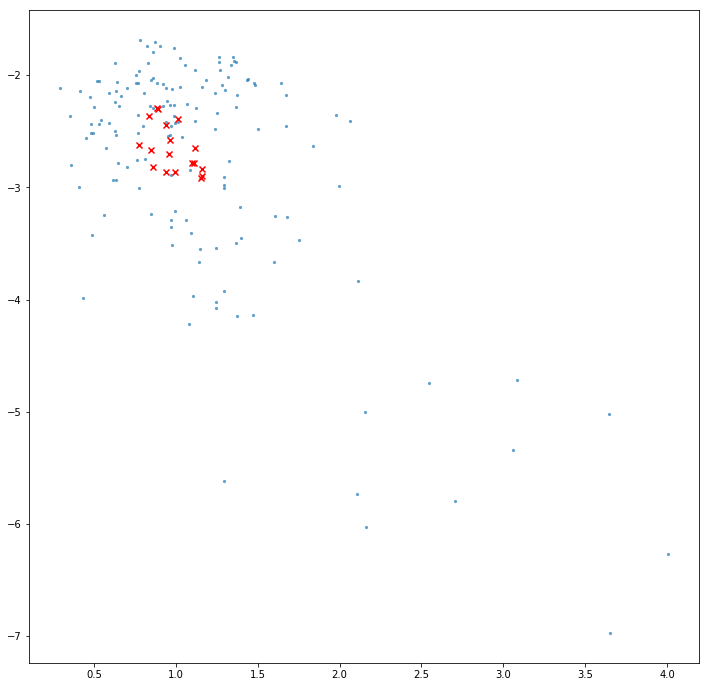

In [19]:
plotData(data[data['usertype'] == 'seed'], data[data['usertype']=='user'], header)

## Followers Network Test - 1

Average P@20: 7.12
Average P@10: 6.03


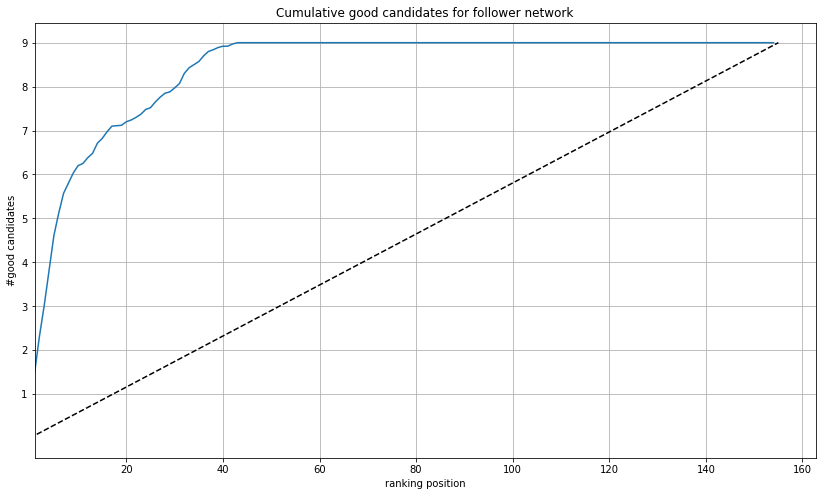

In [23]:
# features file reading and metadata inclusion
userdata = pd.read_csv(path+'social_network_{}_follower_nodes.csv'.format(test), sep='\t')
data = pd.read_csv(path+'social_network_{}_follower.emb'.format(test), sep=' ', header=None, skiprows=1)
data = userdata.merge(data, left_on='id', right_on=0)
data.drop(0, inplace=True, axis=1)

# need to add usernames, too and filter the mentioned users that should not be included
t1_users = testusers[testusers['n_test'] == test][['id_user', 'screen_name']].drop_duplicates()
t1_users['usertype'] = 'user'
data = data.merge(pd.concat([seed_data[['id_user', 'screen_name', 'usertype']], t1_users]), on='id_user')

data.columns = ['id_graph','followers','following','id_user']+header+['username', 'usertype']

perf_follower, candidates_ranking, all_ranking = computePerformance(allseeds, combinations, data, 'follower')

In [22]:
extract_top_list(all_ranking, 20)

,screen_name,ranking
4,angelosbratis,1.608696
1,eeismann,2.040000
0,1darklevel,2.655172
2,amenstyle,2.833333
3,cortomoltedo,4.071429
6,aquilanorimondi,4.785714
11,andrea_pompilio,5.086957
7,arthurarbesser,5.680000
10,aujourlejour_,5.923077
12,10acompany,6.629630


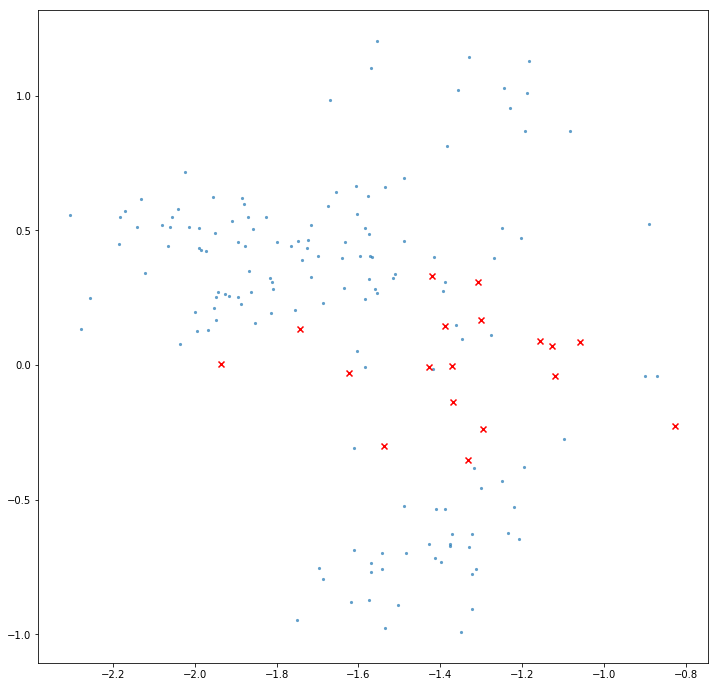

In [21]:
plotData(data[data['usertype'] == 'seed'], data[data['usertype']=='user'], header)

## Complete Social Network Test - 1

Average P@20: 8.27
Average P@10: 6.98


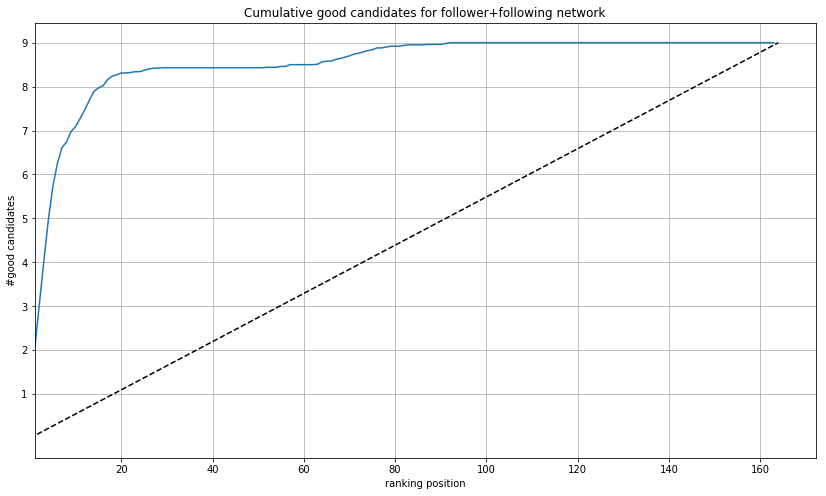

In [24]:
# features file reading and metadata inclusion
userdata = pd.read_csv(path+'social_network_{}_complete_nodes.csv'.format(test), sep='\t')
data = pd.read_csv(path+'social_network_{}_complete.emb'.format(test), sep=' ', header=None, skiprows=1)
data = userdata.merge(data, left_on='id', right_on=0)
data.drop(0, inplace=True, axis=1)
data['id_user'] = data['id_user'].astype(str)

# need to add usernames, too and filter the mentioned users that should not be included
t1_users = testusers[testusers['n_test'] == test][['id_user', 'screen_name']].drop_duplicates()
t1_users['usertype'] = 'user'
all_u = pd.concat([seed_data[['id_user', 'screen_name', 'usertype']], t1_users])
all_u['id_user'] = all_u['id_user'].astype(str)

data_complete = data.merge(all_u, on='id_user')
data_complete.columns = ['id_graph','followers','following','id_user']+header+['username', 'usertype']

perf_complete, candidates_ranking, all_ranking = computePerformance(allseeds, combinations, data_complete, 'follower+following')

In [24]:
extract_top_list(all_ranking, 20)

,screen_name,ranking
0,arthurarbesser,1.200000
2,aincontri,1.718750
1,alabmilano,1.966667
7,alessia_xoccato,2.909091
3,arnoldoebattois,3.333333
8,maisonalbino,3.428571
5,abrahamkhangul1,3.740741
6,andrea_pompilio,4.130435
10,10acompany,4.777778
4,1darklevel,5.275862


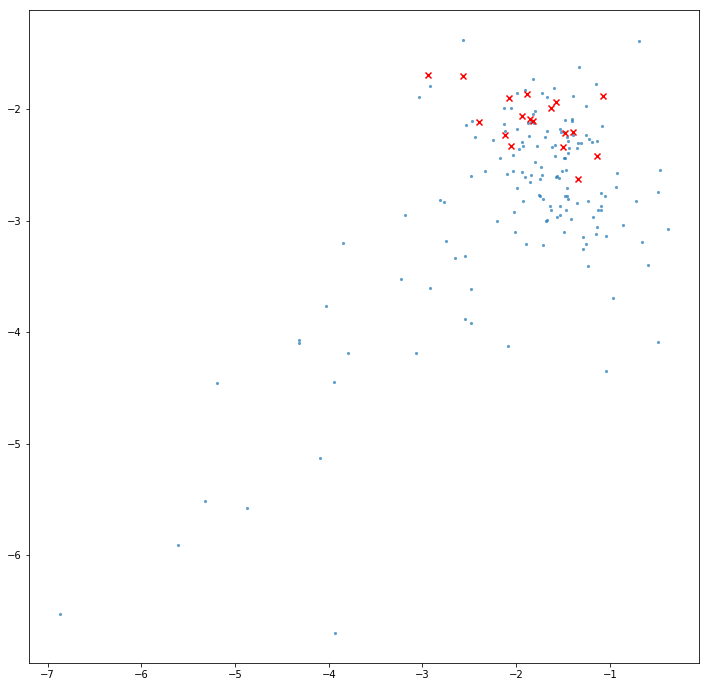

In [23]:
plotData(data_complete[data_complete['usertype'] == 'seed'], data_complete[data_complete['usertype']=='user'], header)

## Reduced Social Network

Average P@20: 7.75
Average P@10: 5.44


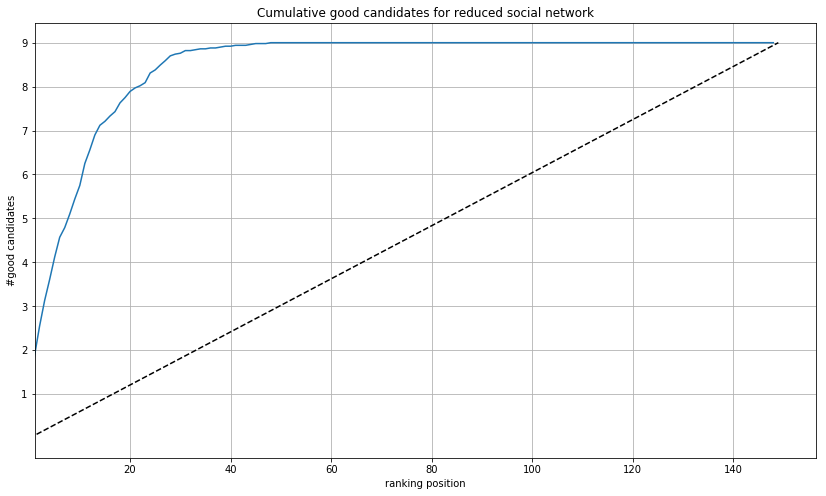

In [25]:
# features file reading and metadata inclusion
header = ['{}'.format(i) for i in range(1,5)]
userdata = pd.read_csv(path+'social_reduced_nodes.csv', sep='\t')
data = pd.read_csv(path+'social_network_reduced_weighted.emb', sep=' ', header=None, skiprows=1)
data = userdata.merge(data, left_on='id', right_on=0)
data.drop(0, inplace=True, axis=1)
data['id_user'] = data['id_user'].astype(str)

# need to add usernames, too and filter the mentioned users that should not be included
t1_users = testusers[testusers['n_test'] == test][['id_user', 'screen_name']].drop_duplicates()
t1_users['usertype'] = 'user'
all_u = pd.concat([seed_data[['id_user', 'screen_name', 'usertype']], t1_users])
all_u['id_user'] = all_u['id_user'].astype(str)

data_complete = data.merge(all_u, on='id_user')

data_complete.columns = ['id_graph','id_user','usertype']+header+['username', 'usertype_x']

perf_social_red, candidates_ranking, all_ranking = computePerformance(allseeds, combinations, data_complete, 'reduced social')

In [26]:
extract_top_list(all_ranking, 20)

,screen_name,ranking
1,aquilanorimondi,1.571429
6,1darklevel,2.655172
0,cortomoltedo,3.000000
10,freshfunk5,3.920000
4,arthurarbesser,4.040000
2,jessicaxo21_,5.300000
9,ruby_pseudo,5.800000
7,aujourlejour_,6.769231
3,angelosbratis,6.869565
16,mweigel,8.500000


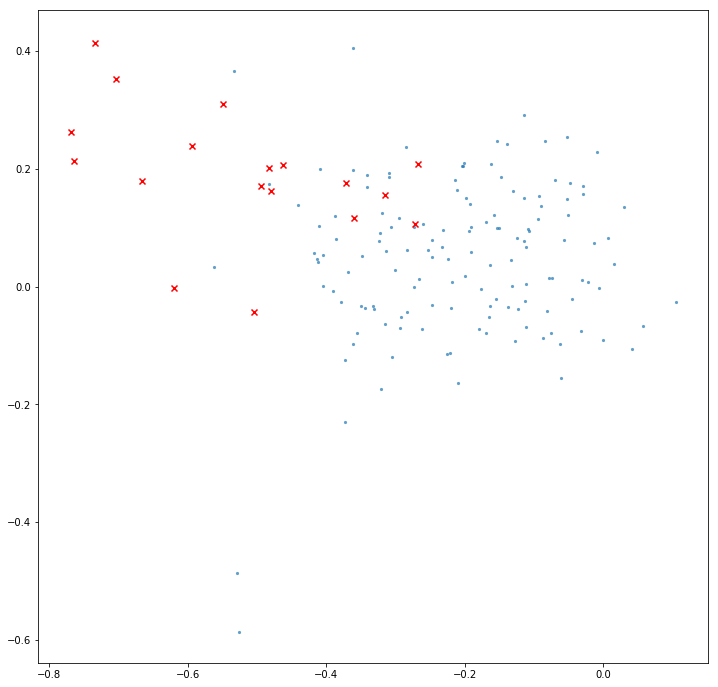

In [31]:
plotData(data_complete[data_complete['usertype'] == 'seed'], data_complete[data_complete['usertype_x']=='user'], header)

## Performance Comparison

In [26]:
print (len(perf_tag), len(perf_mention), len(perf_following), len(perf_follower),len(perf_complete), len(perf_social_red))

169 169 159 155 164 149


In [27]:
pf_1 = np.append(perf_following, [9.]*10)
pf_2 = np.append(perf_follower, [9.]*14)
pf_3 = np.append(perf_complete, [9.]*5)
pf_4 = np.append(perf_social_red, [9.]*20)

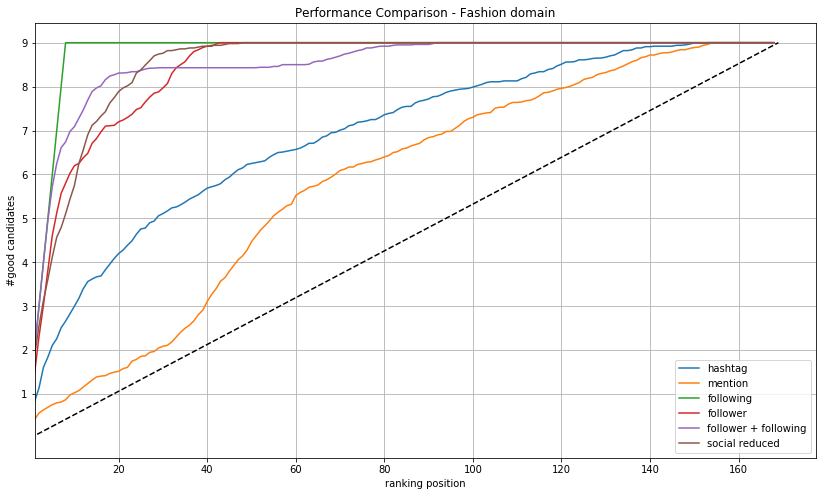

In [28]:
plt.figure(figsize=(14,8))

plt.plot(perf_tag, label='hashtag')
plt.plot(perf_mention, label='mention')
plt.plot(pf_1, label='following')
plt.plot(pf_2, label='follower')
plt.plot(pf_3, label='follower + following')
plt.plot(pf_4, label='social reduced')
plt.plot([0, len(perf_tag)], [0, 9], linestyle='--', color='black')

plt.legend()
plt.title('Performance Comparison - Fashion domain')
plt.ylabel('#good candidates')
plt.xlabel('ranking position')

plt.xlim(xmin=1)
plt.yticks(range(1,10))
plt.grid(True)

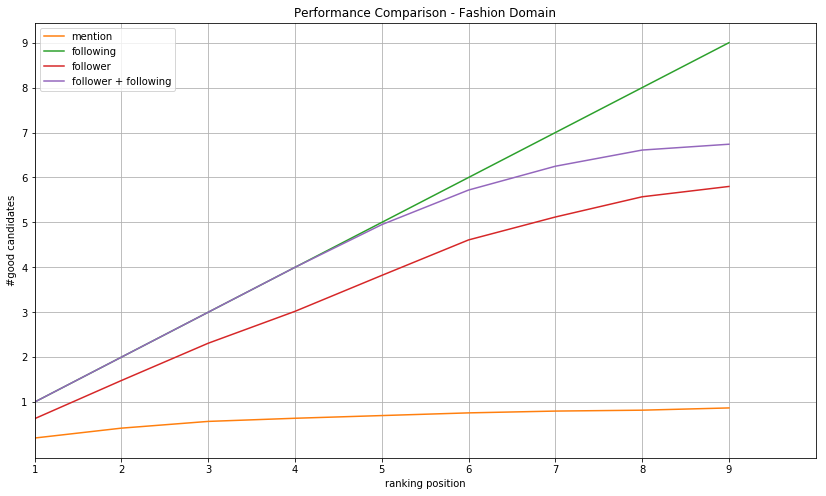

In [29]:
# paper figure

plt.figure(figsize=(14,8))
K = 9

l = plt.plot(perf_tag[:K], label='hashtag')
l.pop(0).remove()

plt.plot(perf_mention[:K], label='mention')
plt.plot(pf_1[:K], label='following')
plt.plot(pf_2[:K], label='follower')
plt.plot(pf_3[:K], label='follower + following')
# plt.plot(pf_4[:K], label='social reduced')
# plt.plot([0, 20], [0, 10], linestyle='--', color='black')


plt.legend()
plt.title('Performance Comparison - Fashion Domain')
plt.ylabel('#good candidates')
plt.xlabel('ranking position')

plt.xlim(xmin=1, xmax=K)
plt.yticks(range(1, K+1))
plt.xticks(range(0, K, 1), [str(i+1) for i in range(K)])
plt.grid(True)